In [ ]:
## @see https://www.kaggle.com/toorkp/churn-wsdm/data

In [1]:
%load_ext autoreload
%autoreload

In [2]:
import numpy as np
import pandas as pd
import time
import gc; gc.enable()
import time
import sys

from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, f1_score, log_loss, confusion_matrix
from sklearn.neural_network import MLPClassifier

from scipy.stats import randint as sp_randint

from collections import Counter
from numpy.random import RandomState
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

pd.options.display.float_format = "{:.2f}".format
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('modules')

from shared_functions import *

/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [28]:
base_dataset = pd.read_hdf('/home/dissertation/data/dfs_dataset.h5', 'dfs_dataset')
# base_dataset.drop(['transaction_date_min', 'transaction_date_max'], axis = 1, inplace=True)
# base_dataset['city'] = base_dataset.city.astype(str)
# base_dataset['registered_via'] = base_dataset.registered_via.astype(str)
base_dataset = base_dataset.reset_index()
base_dataset.head()

,index,msno,is_churn,bd,gender,registration_init_time,city,registered_via,SUM(transactions.payment_plan_days),SUM(transactions.plan_list_price),...,MEAN(transactions.daily_price),COUNT(transactions),PERCENT_TRUE(transactions.is_auto_renew),PERCENT_TRUE(transactions.is_cancel),NUM_UNIQUE(transactions.payment_method_id),MODE(transactions.payment_method_id),DAY(registration_init_time_dt),YEAR(registration_init_time_dt),MONTH(registration_init_time_dt),WEEKDAY(registration_init_time_dt)
0,0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,28,male,20131223,5,3,60.00,298.00,...,inf,6.00,0.83,0.17,2.00,31.00,23,2013,12,0
1,1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,20,male,20131223,13,3,127.00,627.00,...,4.18,5.00,0.00,0.00,3.00,38.00,23,2013,12,0
2,2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,18,male,20131227,13,3,540.00,2682.00,...,4.97,18.00,0.00,0.00,1.00,38.00,27,2013,12,4
3,3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,0,NaN,20140109,1,7,487.00,2384.00,...,inf,19.00,0.95,0.16,2.00,41.00,9,2014,1,3
4,4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,35,female,20140125,13,7,630.00,2529.00,...,inf,24.00,1.00,0.08,1.00,41.00,25,2014,1,5


In [41]:
## Simple Data Prep 
base_dataset = base_dataset.drop(labels =['msno', 'bd', 'index', 'gender'], axis=1)

## TEMP TEMP TEMP ##
for col in base_dataset.head().filter(regex='daily').columns:
    base_dataset.drop(col, axis=1, inplace=True)

## Simply drops records with NA ast this stage
base_dataset = clean_dataset(base_dataset)

print(base_dataset.shape)
base_dataset.head()

(797369, 49)


,is_churn,registration_init_time,city,registered_via,SUM(transactions.payment_plan_days),SUM(transactions.plan_list_price),SUM(transactions.actual_amount_paid),SUM(transactions.transaction_date),SUM(transactions.membership_expire_date),SUM(transactions.price_difference),...,MEAN(transactions.price_difference),COUNT(transactions),PERCENT_TRUE(transactions.is_auto_renew),PERCENT_TRUE(transactions.is_cancel),NUM_UNIQUE(transactions.payment_method_id),MODE(transactions.payment_method_id),DAY(registration_init_time_dt),YEAR(registration_init_time_dt),MONTH(registration_init_time_dt),WEEKDAY(registration_init_time_dt)
0,1,20131223,5,3,60.00,298.00,894.00,120923653.00,120924153.00,428.00,...,71.33,6.00,0.83,0.17,2.00,31.00,23,2013,12,0
1,1,20131223,13,3,127.00,627.00,627.00,100812365.00,100812869.00,0.00,...,0.00,5.00,0.00,0.00,3.00,38.00,23,2013,12,0
2,1,20131227,13,3,540.00,2682.00,2682.00,362862440.00,362881912.00,0.00,...,0.00,18.00,0.00,0.00,1.00,38.00,27,2013,12,4
3,1,20140109,1,7,487.00,2384.00,2682.00,382888820.00,383039868.00,214.00,...,11.26,19.00,0.95,0.16,2.00,41.00,9,2014,1,3
4,1,20140125,13,7,630.00,2529.00,2956.00,483713706.00,483807163.00,341.00,...,14.21,24.00,1.00,0.08,1.00,41.00,25,2014,1,5


In [ ]:
import sklearn 
sklearn.metrics.SCORERS.keys()

In [ ]:
## WHAT METRIC SHOULD BE OPTIMSED AS PART OF CV

In [65]:
RANDOM_STATE = 42 
CV_ITER = 3
SCORING_METRIC = 'recall'

## Each entry in the list is a Tuple of
##   [ModelName, Model, HyperParams, ScoringMetric]
classifiers = [
    ('NB', GaussianNB(), {}, SCORING_METRIC),
    ('DT', DecisionTreeClassifier(), {}, SCORING_METRIC),
    ('RF', RandomForestClassifier(n_jobs =-1), {}, SCORING_METRIC),
    ('LR', LogisticRegression(solver = 'liblinear'), {}, SCORING_METRIC),
    ('AB', AdaBoostClassifier(), {}, SCORING_METRIC),
    ('MLP', MLPClassifier(), {}, SCORING_METRIC),
        ('RF2', RandomForestClassifier(n_jobs =-1), 
                    {'search_type': 'RANDOM_SEARCH_CV',
                     "criterion": ["entropy","gini"], 
                     "n_estimators": sp_randint(100,200),
                     "max_depth":sp_randint(10,30), 
                     "min_samples_leaf":sp_randint(10,50),
                     "min_samples_split":sp_randint(10,100),
                     "class_weight":[None, "balanced"]},
           SCORING_METRIC), 
]

In [61]:
all_metrics = pd.DataFrame()
all_metrics

""


In [45]:
sample_dataset = base_dataset.sample(100000)

In [51]:
sample_dataset.head()

,is_churn,registration_init_time,city,registered_via,SUM(transactions.payment_plan_days),SUM(transactions.plan_list_price),SUM(transactions.actual_amount_paid),SUM(transactions.transaction_date),SUM(transactions.membership_expire_date),SUM(transactions.price_difference),...,MEAN(transactions.price_difference),COUNT(transactions),PERCENT_TRUE(transactions.is_auto_renew),PERCENT_TRUE(transactions.is_cancel),NUM_UNIQUE(transactions.payment_method_id),MODE(transactions.payment_method_id),DAY(registration_init_time_dt),YEAR(registration_init_time_dt),MONTH(registration_init_time_dt),WEEKDAY(registration_init_time_dt)
369955,0,20150406,5,3,690.00,3780.00,3780.00,463625727.00,463645610.00,0.00,...,0.00,23.00,0.48,0.00,1.00,36.00,6,2015,4,0
261624,0,20151029,1,7,480.00,1584.00,1584.00,322570684.00,322581086.00,0.00,...,0.00,16.00,1.00,0.00,1.00,41.00,29,2015,10,3
468797,0,20160808,14,7,210.00,693.00,693.00,141145356.00,141154856.00,0.00,...,0.00,7.00,1.00,0.00,1.00,41.00,8,2016,8,0
513431,0,20120201,1,7,750.00,3725.00,3874.00,524076056.00,524096282.00,107.00,...,4.12,26.00,1.00,0.00,1.00,41.00,1,2012,2,2
48784,1,20160812,10,9,90.00,447.00,447.00,60492138.00,60492439.00,0.00,...,0.00,3.00,0.00,0.00,1.00,38.00,12,2016,8,4


### Experiment 1.1 Baseline - Default Settings - No sampling

Model Build Iteration 0


/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


PRE-SAMPLING: (558158, 48) (558158,) Counter({0: 514716, 1: 43442})
POST-SAMPLING: (558158, 48) (558158,) Counter({0: 514716, 1: 43442})
Applying normalisation to train and test sets
Categorical columns in dataset ['city', 'registered_via']
Categorical columns in dataset ['city', 'registered_via']
X_train:  (558158, 83) (558158, 1)
X_test:  (239211, 83) (239211, 1)


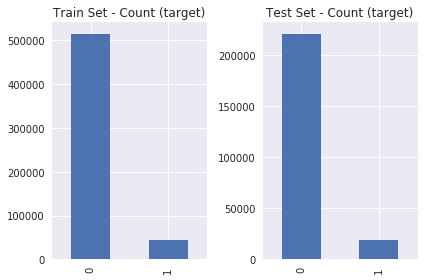

Building NB classifier
No params set, using Standard training
Performing 3-fold CV on test set using recall metric
P_Recall: 0.006; N_Recall: 1.0
Building DT classifier
No params set, using Standard training
Performing 3-fold CV on test set using recall metric
P_Recall: 0.472; N_Recall: 0.955
Building RF classifier
No params set, using Standard training
Performing 3-fold CV on test set using recall metric
P_Recall: 0.398; N_Recall: 0.989
Building LR classifier
No params set, using Standard training
Performing 3-fold CV on test set using recall metric


/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


P_Recall: 0.0; N_Recall: 1.0
Building AB classifier
No params set, using Standard training
Performing 3-fold CV on test set using recall metric
P_Recall: 0.311; N_Recall: 0.993
Building MLP classifier
No params set, using Standard training
Performing 3-fold CV on test set using recall metric
P_Recall: 1.0; N_Recall: 0.0
Building RF2 classifier
Optimising using RandomizedSearchCV
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=38, min_samples_split=41, n_estimators=109 
[CV] class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=38, min_samples_split=41, n_estimators=109 
[CV] class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=38, min_samples_split=41, n_estimators=109 
[CV] class_weight=None, criterion=entropy, max_depth=20, min_samples_leaf=11, min_samples_split=25, n_estimators=138 
[CV] class_weight=None, criterion=entropy, max_depth=20, min_samples_leaf=11, min_sam

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 23.7min finished


CLF: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 14, 'min_samples_leaf': 25, 'min_samples_split': 98, 'n_estimators': 159}
Performing 3-fold CV on test set using recall metric
P_Recall: 0.765; N_Recall: 0.875


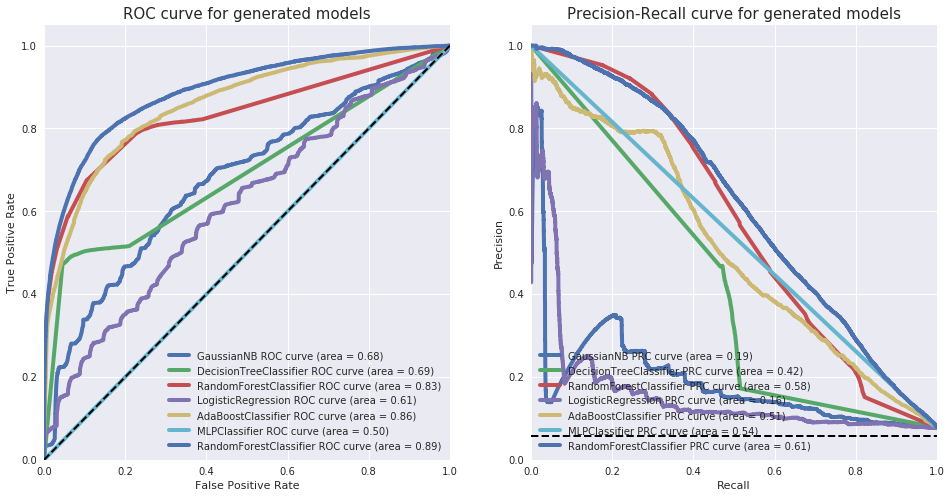

CPU times: user 15min 12s, sys: 1min 22s, total: 16min 34s
Wall time: 29min 19s


In [66]:
%%time
sampler = ('None', DummySampler())

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER, 
                                 cat_col = ['city','registered_via'])

all_metrics = all_metrics.append(exp_metrics)

In [67]:
all_metrics.sort_values('f1_score', ascending=False)

,classifier,sampling_method,tn,fn,tp,fp,accuracy,precision,recall,f1_score,log_loss,time_taken,aucroc,auprc,bal_acc,cv_score_mean,cv_score_std,model_churn_cost,sample
0,RandomForestClassifier,None,218173,11202,7416,2420,0.94,0.75,0.40,0.52,1.97,26.43,0.83,0.58,0.69,0.38,0.01,3477700.00,0
0,RandomForestClassifier,None,192909,4379,14239,27684,0.87,0.34,0.76,0.47,4.63,1509.65,0.89,0.61,0.82,0.75,0.01,3546875.00,0
0,DecisionTreeClassifier,None,210615,9838,8780,9978,0.92,0.47,0.47,0.47,2.86,20.99,0.69,0.42,0.71,0.46,0.01,3616900.00,0
0,AdaBoostClassifier,None,219021,12820,5798,1572,0.94,0.79,0.31,0.45,2.08,82.15,0.86,0.51,0.65,0.31,0.02,3718450.00,0
0,MLPClassifier,None,2,2,18616,220591,0.08,0.08,1.00,0.14,31.85,17.63,0.50,0.54,0.50,0.00,0.00,12426250.00,0
0,GaussianNB,None,220556,18501,117,37,0.92,0.76,0.01,0.01,2.68,1.73,0.68,0.19,0.50,0.01,0.00,4635875.00,0
0,LogisticRegression,None,220593,18618,0,0,0.92,0.00,0.00,0.00,2.69,2.85,0.61,0.16,0.50,0.00,0.00,4654500.00,0


In [71]:
y_test.value_counts()

NameError: name 'y_test' is not defined

In [69]:
218173+11202+7416+2420

239211

In [ ]:
CLF: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 39, 'min_samples_split': 75, 'n_estimators': 162}
Performing 3-fold CV on test set
P_Recall: 0.747; N_Recall: 0.853
        
        

### Experiment 1.2 Baseline - Default Settings - Oversampled training set 100%

In [ ]:
%%time
sampler = ('ROS 1:1', RandomOverSampler(random_state=RANDOM_STATE))

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER, cat_col = ['city','registered_via', 'gender'])

all_metrics = all_metrics.append(exp_metrics)

### Experiment 1.3 Baseline - Default Settings - Undersampled training set

In [ ]:
sampler = ('RUS 1:1', RandomUnderSampler(random_state=RANDOM_STATE))

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER, cat_col = ['city','registered_via', 'gender'])

all_metrics = all_metrics.append(exp_metrics)

### Experiment 1.4 Baseline - Default Settings - Over sampling - 33% of majority size

In [ ]:
sampler = ('ROS 3:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/3))

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER, cat_col = ['city','registered_via', 'gender'])

all_metrics = all_metrics.append(exp_metrics)

### Experiment 1.5 Baseline - Default Settings - Over sampling - 66% of majority size

In [ ]:
sampler = ('ROS 3:2', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 2/3))

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER, cat_col = ['city','registered_via', 'gender'])

all_metrics = all_metrics.append(exp_metrics)

### Experiment 1.6 Baseline - Default Settings - Over sampling - 50% of majority size

In [ ]:
sampler = ('ROS 2:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/2))

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER, cat_col = ['city','registered_via', 'gender'])

all_metrics = all_metrics.append(exp_metrics)

### Experiment 1.7 Baseline Default Settings SMOTE-NC

In [ ]:
sampler = ('SMOTE_NC', SMOTENC(random_state=RANDOM_STATE, categorical_features=[0,1,2,3,4,5,6,7,8,13,14], n_jobs=8))

## Keep the following, essentially dropping the dt columns
cols = ['is_churn', 'city', 'gender', 'age_cat', 'registered_via', 'total_order',
       'payment_method_id_mode', 'payment_method_id_count',
       'payment_plan_days_mode', 'payment_plan_days_mean',
       'plan_list_price_mean', 'plan_lifetime_value', 'actual_amount_mean',
       'total_actual_amount', 'is_auto_renew_mode', 'cancel_times','transaction_date_delta']

exp_metrics = perform_experiment(base_dataset[cols], classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER, cat_col = ['city','registered_via', 'gender'])

all_metrics = all_metrics.append(exp_metrics)

In [ ]:
all_metrics.sort_values('model_churn_cost', ascending=True)

In [ ]:
## Just try an SVM 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [ ]:
%%time
model_train_results = train_model(base_dataset, sampling_method = 'under', classifiers = [('SGDClassifier', SGDClassifier(loss='log'))])

In [ ]:
## Print the feature importance 

feature_index = np.flip(np.argsort(model.feature_importances_), axis=0)
ordered_features = []
column_names = X_test.columns

for i in feature_index[0:10]:
    print(np.round(model.feature_importances_[i], 3), ' --> ', column_names[i])
    ordered_features.append(column_names[i])

In [ ]:
## Print the permutation importance 

import eli5
from eli5.sklearn import PermutationImportance

_, X_test, _, y_test = prepare_train_test_split(model_dataset, 0)

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [ ]:
#model_name, model = model_train_results[1][2]

for model_name, model in model_train_results[1]:
    probs = model.predict_proba(X_test)[:, 1]
    pr_data = plot_precision_recall(
        y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
pr_data = plot_roc(
    y_test, probs, title='ROC Curve for {0}'.format(model_name))

In [ ]:
print(plt.style.available)

In [ ]:
model_dataset.head()

In [ ]:
print("Original Data distribution")
print(model_dataset['is_churn'].value_counts())

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Down Sampled data set')
train_downsample = undersampled_dataset(model_dataset, 'is_churn')

print(train_downsample['is_churn'].value_counts())
print("Num records = ", train_downsample.shape[0])
train_downsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Up Sampled data set')
train_upsample = oversampled_dataset(model_dataset, 'is_churn')

print(train_upsample['is_churn'].value_counts())
print("Num records = ", train_upsample.shape[0])
train_upsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='Precision-Recall Curve for Random Forest')

In [ ]:
precision_above = pr_data.loc[pr_data['precision'] >= 0.25].copy()
precision_above.sort_values('recall', ascending=False, inplace=True)
precision_above.head()

In [ ]:
threshold_required = 0.5
# Make predictions where probability is above threshold
preds = np.zeros(len(y_test))
preds[probs >= threshold_required] = 1

# Make and plot confusion matrix
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=['No Churn', 'Churn'],
                      title='Churn Confusion Matrix')

In [ ]:
model_dataset.head()

In [ ]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index=model_dataset.iloc[:, 1:].columns).\
    sort_values('importance', ascending=False)
fi.head(10)